In [36]:
using Plots
using LinearAlgebra

In [138]:
# A and B
A = [0.704 0 0; 0 1 -.154; 0 1 0]
B = [0.144 0; 0 0.206; 0 0]

# Mapping from individual X_i to X
Xv = [1 1 -1]

# D and F
D = Xv*A
F = Xv*B

# Check against calculation
# D = [0.704 0 -0.154]
# F = [0.144 0.206]




1×2 Array{Float64,2}:
 0.144  0.206

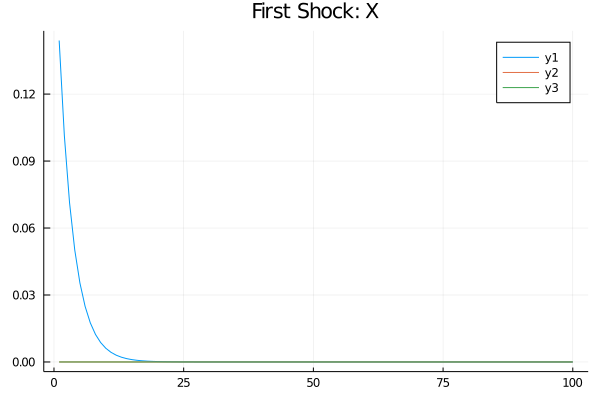

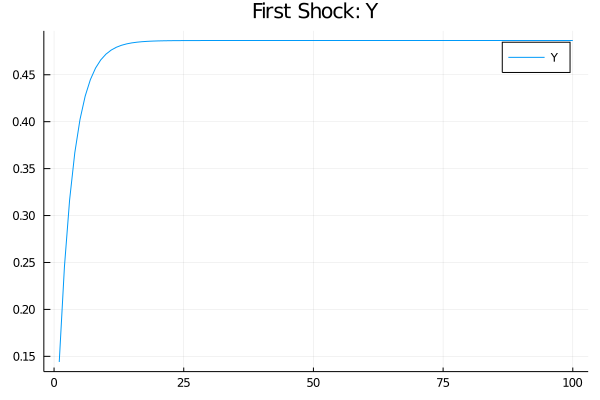

In [156]:
# Impulse horizon
n = 100

# First impulse

# Initialize
X1 = zeros(n,3)
Y1 = zeros(n)
W1 = [1 0]

# Shock the beginning
X1[1,:] = B * W1'
Y1[1] = (F*W1')[1]

# Update hidden state and state, using W = 0 for all other W
for i in 2:n
    X1[i,:] = A*X1[i-1,:]
    Y1[i] = Y1[i-1] + (D*X1[i-1,:])[1]
end

# Plots
pX1 = plot(X1, title = "First Shock: X")
display(pX1)
pY1 = plot(Y1, title = "First Shock: Y", label = "Y")
display(pY1)

savefig(pY1, "pY1.png")

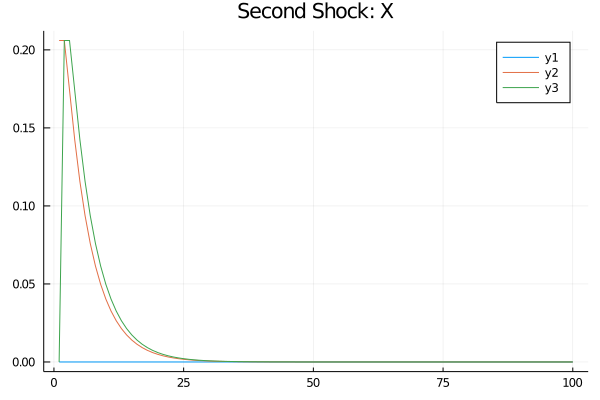

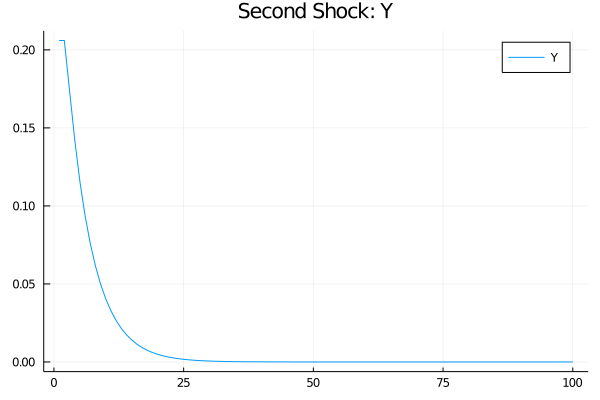

In [158]:
# Second impulse
X2 = zeros(n,3)
Y2 = zeros(n)
W2 = [0 1]

# Shock
X2[1,:] = B * W2'
Y2[1] = (F*W2')[1]

# Run forward
for i in 2:n
    X2[i,:] = A*X2[i-1,:]
    Y2[i] = Y2[i-1] + (D*X2[i-1,:])[1]
end

# Plot
pX2 = plot(X2, title = "Second Shock: X")
display(pX2)
pY2 = plot(Y2, title = "Second Shock: Y", label = "Y")
display(pY2)

savefig(pY2, "pY2.png")

In [149]:
# Kalman filter
function K(Sig)
    return (A*Sig*D' + B*F')*inv(D*Sig*D' + F*F')
end

# Update hiddens state variance
function update_Sig(Sig)
    return A*Sig*A' + B*B' - K(Sig)*(D*Sig*A' + F*B')
end

# Update hidden state mean
function update_Xbar(Xbar, Sig, W)
    return A*Xbar + K(Sig)*Fbar*W
end

# Update Y
function update_Y(Y, Xbar, W, D)
    return Y + (D*Xbar)[1] + (Fbar*W)[1]
end

# Start at identity
S_init = I(3)

# Iterate until close to fixed point (convergence is fast)
m = 100
Sigs = zeros(m,size(S_init,1), size(S_init,2))
Sigs[1,:,:] = S_init

for i in 2:m
    Sigs[i,:,:] = update_Sig(Sigs[i-1,:,:])
end

# Converged Sigma and K(Sigma)
Sig_con = Sigs[m,:,:]
K_Sig_con = K(Sig_con)
println("K_Sig_con: ", K_Sig_con)

# Omega
Omega = D*Sig_con*D' + F*F'

# Fbar
Fbar = sqrt(Omega)



K_Sig_con: [0.3927086919669648; 0.1603465916219554; -0.44694471641107986]


1×1 Array{Float64,2}:
 0.27428345313229574

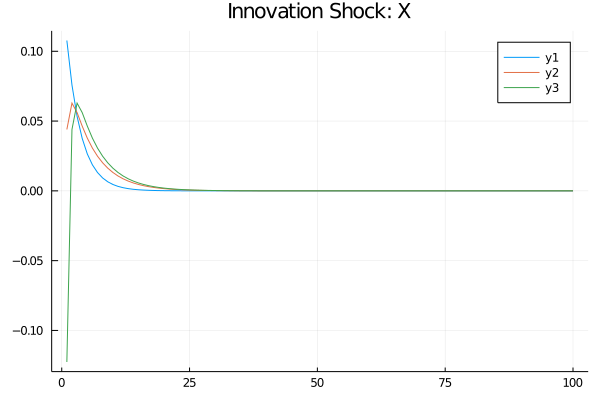

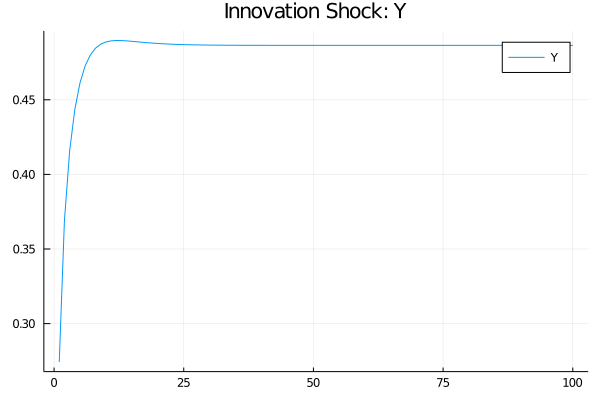

In [157]:
# Innovation impulse
n = 100
X_inn = zeros(n,3)
Y_inn = zeros(n)
W_inn = 1

# Shock
X_inn[1,:] = K_Sig_con.* Fbar * W_inn
Y_inn[1] = (Fbar .* W_inn)[1]

# Run forward
for i in 2:n
    X_inn[i,:] = update_Xbar(X_inn[i-1,:], Sig_con, 0.0, Fbar)
    Y_inn[i] = update_Y(Y_inn[i-1], X_inn[i-1,:], 0.0, D, Fbar)
end


pX_inn = plot(X_inn, title = "Innovation Shock: X")
display(pX_inn)
pY_inn = plot(Y_inn, title = "Innovation Shock: Y", label = "Y")
display(pY_inn)

savefig(pY_inn, "pY_inn.png")